# 정규화 미적용

[TRAIN] 교집합 개수: 1455 / TS=1455 ST=1477
[VALID] 교집합 개수: 160 / TS=160 ST=164
[TEST] 교집합 개수: 272 / TS=272 ST=295


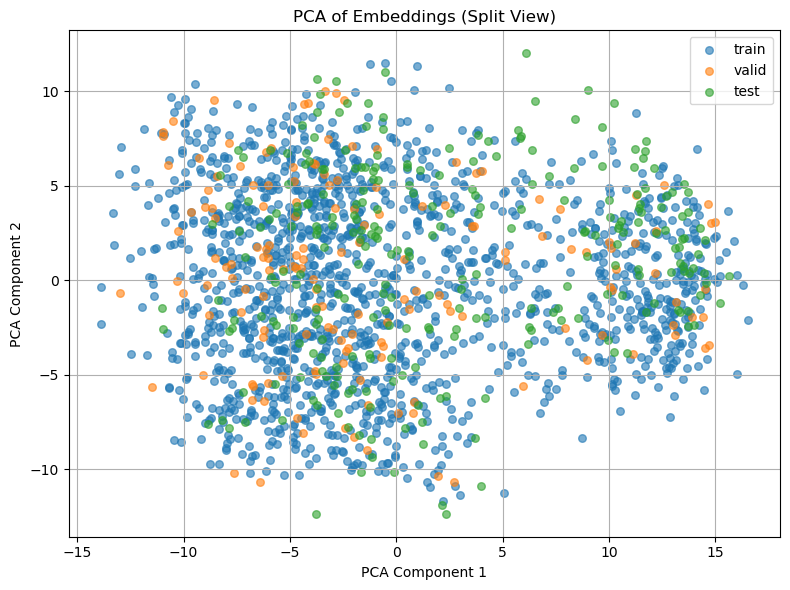

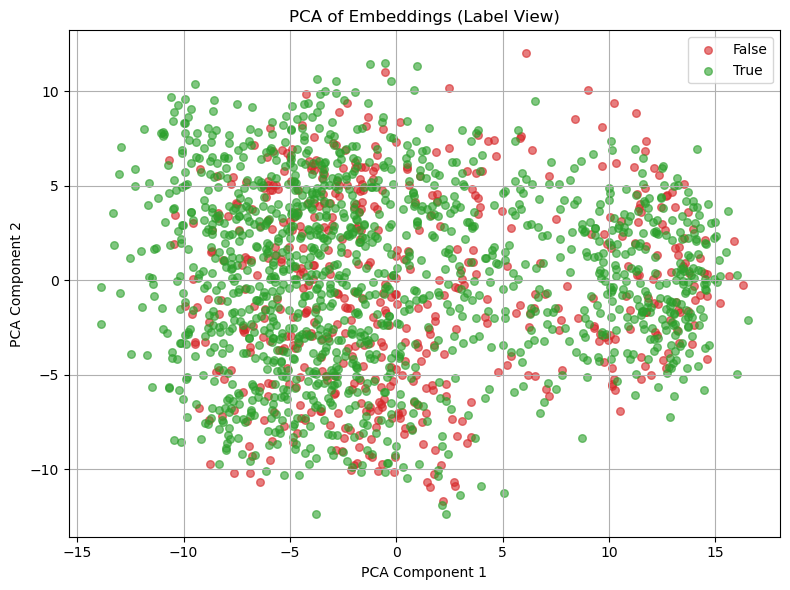

In [2]:
# 📌 통합 PCA 시각화: TimeSformer + ST-GCN 정렬 포함
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

# ───────────── 설정 ─────────────
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "flatten"  # "mean", "max", "flatten" 중 선택

# ───────────── 함수 정의 ─────────────
def load_split(split, model):
    base = DATA_ROOT / model / split
    emb_path = base / "embeddings.npy"
    lbl_path = base / "labels.npy"
    ids_path = base / "ids.npy"
    if not emb_path.exists() or not lbl_path.exists() or not ids_path.exists():
        return None, None, None
    emb = np.load(emb_path)
    lbl = np.load(lbl_path).ravel()
    ids = np.load(ids_path, allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if arr is None or len(arr) == 0:
        return np.empty((0, 0))
    if AGG_METHOD == "mean":    return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":     return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten": return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

def align_by_ids(base_ids, target_embs, target_ids):
    id_to_emb = {k: v for k, v in zip(target_ids, target_embs)}
    aligned_embs = [id_to_emb[i] for i in base_ids if i in id_to_emb]
    return np.array(aligned_embs)

def load_and_align(split):
    X_ts, y, ids_ts = load_split(split, "timesformer")
    X_st, _, ids_st = load_split(split, "stgcnpp")

    if X_ts is None or X_st is None:
        return np.empty((0, 0)), np.array([])

    # 만약 타입이 다르면 str로 통일
    ids_ts = np.array(ids_ts).astype(str)
    ids_st = np.array(ids_st).astype(str)

    inter = set(ids_ts) & set(ids_st)
    print(f"[{split.upper()}] 교집합 개수: {len(inter)} / TS={len(ids_ts)} ST={len(ids_st)}")
    if len(inter) == 0:
        print(f"❌ {split} : 두 ids 간 교집합이 0개입니다. 파일, 타입, 경로 재확인 필요!")
        return np.empty((0, 0)), np.array([])

    X_st = align_by_ids(ids_ts, X_st, ids_st)
    X_st = reduce_stgcn(X_st)

    if len(X_ts) != len(X_st):
        print(f"❌ {split} 정렬 실패: TS={len(X_ts)}, ST={len(X_st)}")
        return np.empty((0, 0)), np.array([])

    X_concat = np.concatenate([X_ts, X_st], axis=1)
    return X_concat, y


# ───────────── 정렬 및 결합 ─────────────
X_tr, y_tr = load_and_align("train")
X_va, y_va = load_and_align("valid")
X_te, y_te = load_and_align("test")

X_all = np.vstack([X_tr, X_va, X_te])
y_all_split = (
    ["train"] * len(X_tr) +
    ["valid"] * len(X_va) +
    ["test"]  * len(X_te)
)
y_all_label = np.concatenate([y_tr, y_va, y_te])

if len(X_all) == 0:
    raise ValueError("모든 split에서 정렬된 데이터가 없습니다. 경로 및 ID 정렬 상태를 확인하세요.")

# ───────────── PCA 변환 ─────────────
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all)

# ───────────── 시각화 1: split 기준 ─────────────
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, s in enumerate(y_all_split) if s == label]
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label, alpha=0.6, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (Split View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ───────────── 시각화 2: 라벨 기준 ─────────────
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['False', 'True']):
    idx = y_all_label == label
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=name, alpha=0.6, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (Label View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# 정규화 적용

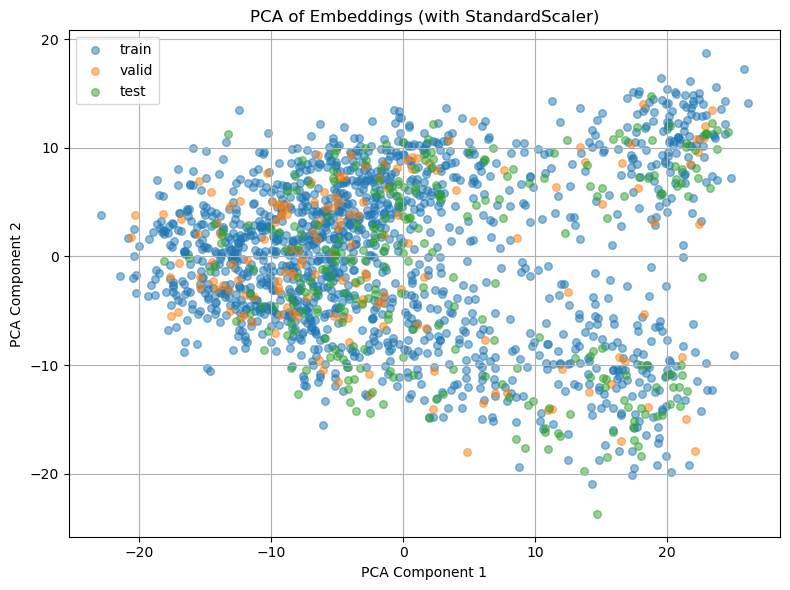

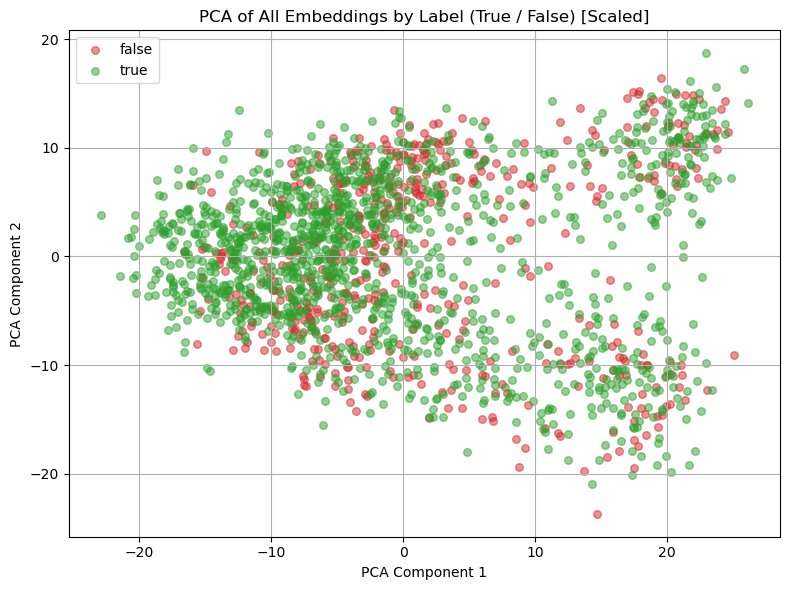

In [3]:
# 📌 TimeSformer + ST-GCN 임베딩 결합 (ID 정렬 포함, StandardScaler)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# ───────────── 설정 ─────────────
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "max"  # "mean", "max", "flatten" 중 선택

# ───────────── 함수 정의 ─────────────
def load_split(split, model):
    base = DATA_ROOT / model / split
    emb_path = base / "embeddings.npy"
    lbl_path = base / "labels.npy"
    ids_path = base / "ids.npy"
    if not emb_path.exists() or not lbl_path.exists() or not ids_path.exists():
        print(f"⚠️ {split}/{model} 경로에 필요한 파일이 없습니다. 스킵합니다.")
        return None, None, None
    emb = np.load(emb_path)
    lbl = np.load(lbl_path).ravel()
    ids = np.load(ids_path, allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if arr is None or len(arr) == 0:
        return np.empty((0, 0))
    if AGG_METHOD == "mean":    return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":     return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten": return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

def align_by_ids(base_ids, target_embs, target_ids):
    id_to_emb = {k: v for k, v in zip(target_ids, target_embs)}
    aligned_embs = [id_to_emb[i] for i in base_ids if i in id_to_emb]
    return np.array(aligned_embs)

def load_and_align(split):
    X_ts, y, ids_ts = load_split(split, "timesformer")
    X_st, _, ids_st = load_split(split, "stgcnpp")

    if X_ts is None or X_st is None:
        return np.empty((0, 0)), np.array([])

    X_st = align_by_ids(ids_ts, X_st, ids_st)
    X_st = reduce_stgcn(X_st)

    if len(X_ts) != len(X_st):
        print(f"❌ {split} 정렬 실패: TS={len(X_ts)}, ST={len(X_st)})")
        return np.empty((0, 0)), np.array([])

    X_concat = np.concatenate([X_ts, X_st], axis=1)
    return X_concat, y

# ───────────── 정렬 및 결합 ─────────────
X_tr, y_tr = load_and_align("train")
X_va, y_va = load_and_align("valid")
X_te, y_te = load_and_align("test")

X_all = np.vstack([X_tr, X_va, X_te])
y_all_split = (
    ["train"] * len(X_tr) +
    ["valid"] * len(X_va) +
    ["test"]  * len(X_te)
)
y_all_label = np.concatenate([y_tr, y_va, y_te])

if len(X_all) == 0:
    raise ValueError("모든 split에서 정렬된 데이터가 없습니다. 경로 및 ID 정렬 상태를 확인하세요.")

# ───────────── 정규화 및 PCA ─────────────
scaler = StandardScaler().fit(np.vstack([X_tr, X_va]))  # train+valid 기준으로 fit
X_tr_scaled = scaler.transform(X_tr)
X_va_scaled = scaler.transform(X_va)
X_te_scaled = scaler.transform(X_te)
X_all_scaled = np.vstack([X_tr_scaled, X_va_scaled, X_te_scaled])

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all_scaled)

# ───────────── 시각화 1: split 기준 ─────────────
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, s in enumerate(y_all_split) if s == label]
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label, alpha=0.5, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (with StandardScaler)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ───────────── 시각화 2: 라벨 기준 ─────────────
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_label == label
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=name, alpha=0.5, s=30, color=color)
plt.legend()
plt.title("PCA of All Embeddings by Label (True / False) [Scaled]")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


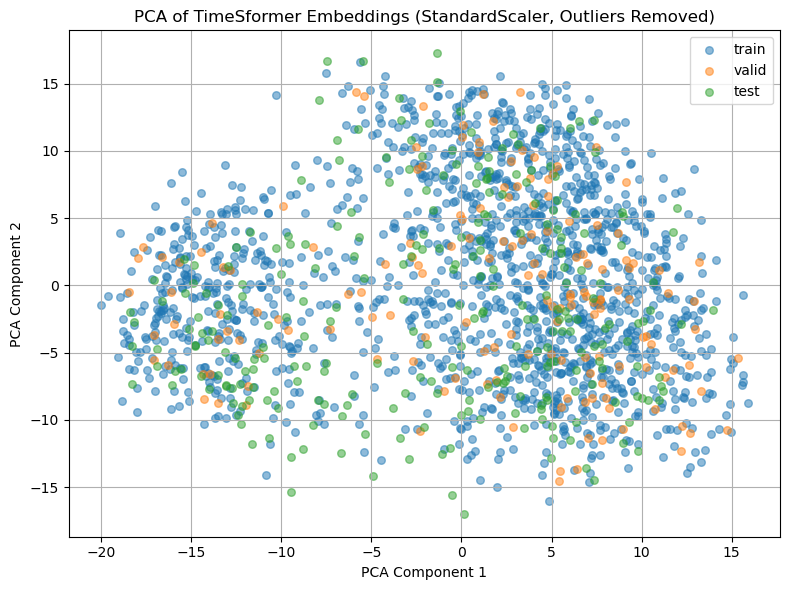

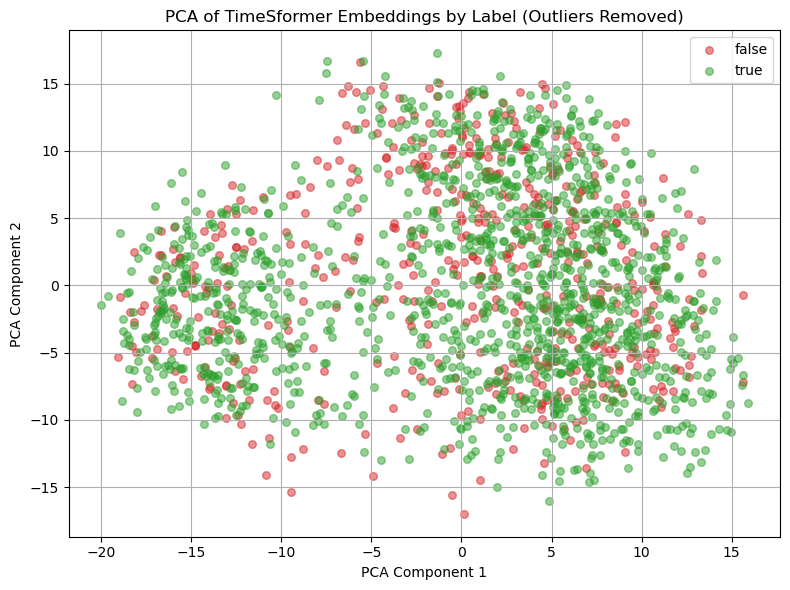

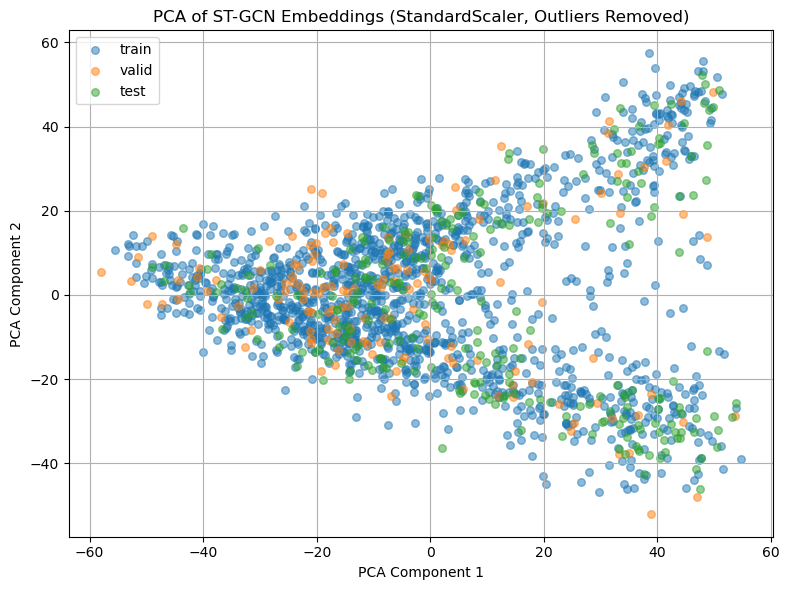

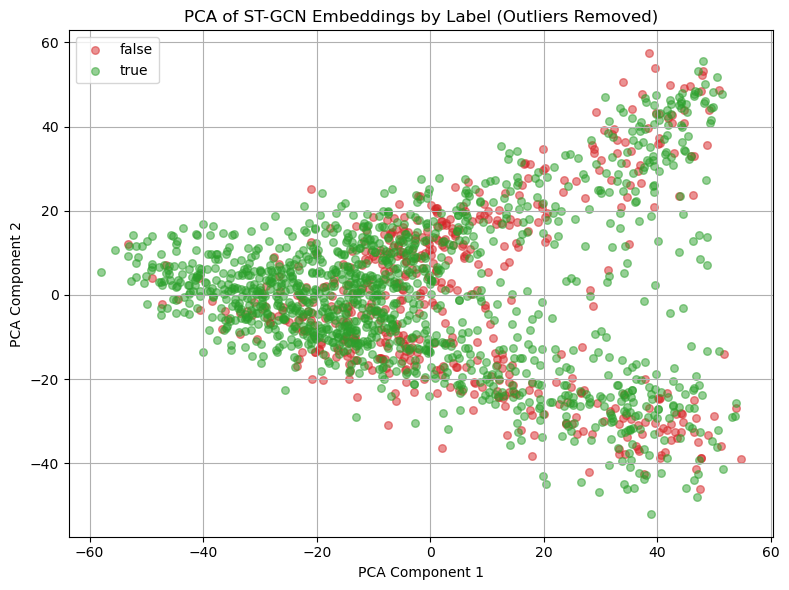

In [4]:
# 📌 TimeSformer + ST-GCN 임베딩 결합 (ID 정렬 포함, StandardScaler)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from scipy.stats import zscore

# ───────────── 설정 ─────────────
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "flatten"  # "mean", "max", "flatten" 중 선택

# ───────────── 개별 스트림 로드 및 정렬 ─────────────
def load_and_align_separately(split):
    X_ts, y, ids_ts = load_split(split, "timesformer")
    X_st, _, ids_st = load_split(split, "stgcnpp")

    if X_ts is None or X_st is None:
        return np.empty((0, 0)), np.empty((0, 0)), np.array([])

    X_st = align_by_ids(ids_ts, X_st, ids_st)
    X_st = reduce_stgcn(X_st)

    if len(X_ts) != len(X_st):
        print(f"❌ {split} 정렬 실패: TS={len(X_ts)}, ST={len(X_st)})")
        return np.empty((0, 0)), np.empty((0, 0)), np.array([])

    return X_ts, X_st, y

# ───────────── 이상치 배제 함수 ─────────────
def remove_outliers(X, y, z_thresh=3.0, min_valid_ratio=0.95):
    z = np.abs(zscore(X, axis=0, nan_policy='omit'))
    # 전체 feature 중 min_valid_ratio 이상이 z_thresh 이하면 통과
    mask = (z < z_thresh).sum(axis=1) >= (X.shape[1] * min_valid_ratio)
    return X[mask], y[mask], mask

# ───────────── split 별 로드 ─────────────
X_ts_tr, X_st_tr, y_tr = load_and_align_separately("train")
X_ts_va, X_st_va, y_va = load_and_align_separately("valid")
X_ts_te, X_st_te, y_te = load_and_align_separately("test")

# ───────────── 전체 결합 ─────────────
X_ts_all = np.vstack([X_ts_tr, X_ts_va, X_ts_te])
X_st_all = np.vstack([X_st_tr, X_st_va, X_st_te])
y_all_split = (
    ["train"] * len(X_ts_tr) +
    ["valid"] * len(X_ts_va) +
    ["test"]  * len(X_ts_te)
)
y_all_label = np.concatenate([y_tr, y_va, y_te])

# ───────────── 이상치 배제 (TS, ST-GCN 각각) ─────────────
X_ts_all_no_out, y_all_label_ts, mask_ts = remove_outliers(X_ts_all, y_all_label, z_thresh=3.0)
y_all_split_ts = np.array(y_all_split)[mask_ts]

X_st_all_no_out, y_all_label_st, mask_st = remove_outliers(X_st_all, y_all_label, z_thresh=3.0)
y_all_split_st = np.array(y_all_split)[mask_st]

# ───────────── 정규화 및 PCA (TS) ─────────────
scaler_ts = StandardScaler().fit(np.vstack([X_ts_tr, X_ts_va]))
X_ts_all_scaled = scaler_ts.transform(X_ts_all_no_out)
X_ts_2d = PCA(n_components=2).fit_transform(X_ts_all_scaled)

# ───────────── 정규화 및 PCA (ST-GCN) ─────────────
scaler_st = StandardScaler().fit(np.vstack([X_st_tr, X_st_va]))
X_st_all_scaled = scaler_st.transform(X_st_all_no_out)
X_st_2d = PCA(n_components=2).fit_transform(X_st_all_scaled)

# ───────────── 시각화: TimeSformer 기준 (split별) ─────────────
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, s in enumerate(y_all_split_ts) if s == label]
    plt.scatter(X_ts_2d[idx, 0], X_ts_2d[idx, 1], label=label, alpha=0.5, s=30, color=color)
plt.title("PCA of TimeSformer Embeddings (StandardScaler, Outliers Removed)")
plt.xlabel("PCA Component 1"); plt.ylabel("PCA Component 2")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# ───────────── 시각화: TimeSformer 기준 (라벨별) ─────────────
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_label_ts == label
    plt.scatter(X_ts_2d[idx, 0], X_ts_2d[idx, 1], label=name, alpha=0.5, s=30, color=color)
plt.title("PCA of TimeSformer Embeddings by Label (Outliers Removed)")
plt.xlabel("PCA Component 1"); plt.ylabel("PCA Component 2")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# ───────────── 시각화: ST-GCN 기준 (split별) ─────────────
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, s in enumerate(y_all_split_st) if s == label]
    plt.scatter(X_st_2d[idx, 0], X_st_2d[idx, 1], label=label, alpha=0.5, s=30, color=color)
plt.title("PCA of ST-GCN Embeddings (StandardScaler, Outliers Removed)")
plt.xlabel("PCA Component 1"); plt.ylabel("PCA Component 2")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# ───────────── 시각화: ST-GCN 기준 (라벨별) ─────────────
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_label_st == label
    plt.scatter(X_st_2d[idx, 0], X_st_2d[idx, 1], label=name, alpha=0.5, s=30, color=color)
plt.title("PCA of ST-GCN Embeddings by Label (Outliers Removed)")
plt.xlabel("PCA Component 1"); plt.ylabel("PCA Component 2")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()



# t-SNE UMAP

c:\Users\qqppq\anaconda3\envs\classifier_fusion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


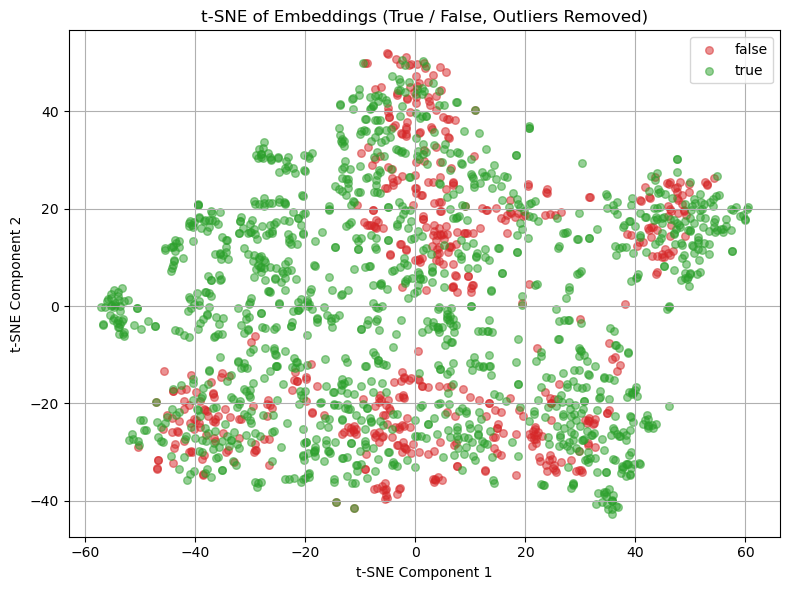

c:\Users\qqppq\anaconda3\envs\classifier_fusion\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


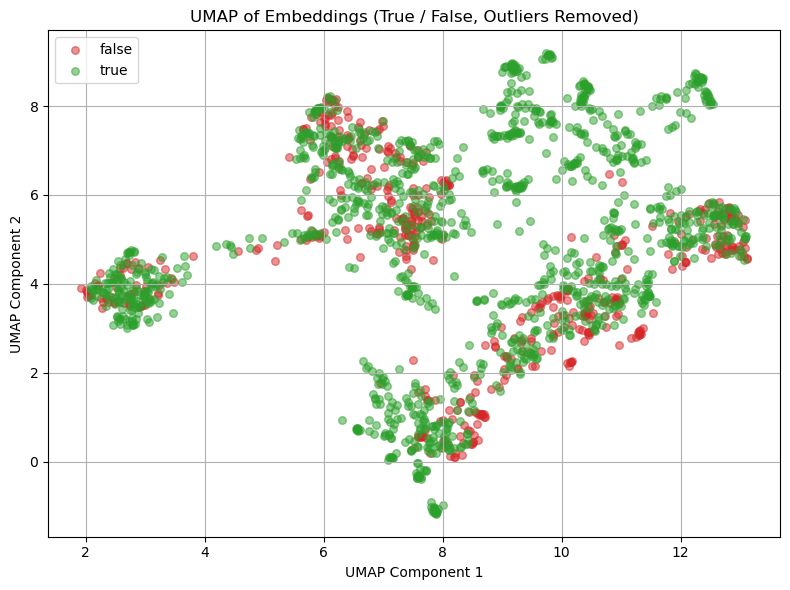

In [5]:
# 📌 TimeSformer + ST-GCN t-SNE/UMAP 시각화 (ID 정렬 결합 버전)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from scipy.stats import zscore

# ---------- [아래는 PCA와 동일한 ID 정렬 & 결합 파트] ----------
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "max"  # "mean", "max", "flatten" 중 선택

def load_split(split, model):
    base = DATA_ROOT / model / split
    emb_path = base / "embeddings.npy"
    lbl_path = base / "labels.npy"
    ids_path = base / "ids.npy"
    if not emb_path.exists() or not lbl_path.exists() or not ids_path.exists():
        print(f"⚠️ {split}/{model} 경로에 필요한 파일이 없습니다. 스킵합니다.")
        return None, None, None
    emb = np.load(emb_path)
    lbl = np.load(lbl_path).ravel()
    ids = np.load(ids_path, allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if arr is None or len(arr) == 0:
        return np.empty((0, 0))
    if AGG_METHOD == "mean":    return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":     return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten": return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

def align_by_ids(base_ids, target_embs, target_ids):
    id_to_emb = {k: v for k, v in zip(target_ids, target_embs)}
    aligned_embs = [id_to_emb[i] for i in base_ids if i in id_to_emb]
    return np.array(aligned_embs)

def load_and_align(split):
    X_ts, y, ids_ts = load_split(split, "timesformer")
    X_st, _, ids_st = load_split(split, "stgcnpp")

    if X_ts is None or X_st is None:
        return np.empty((0, 0)), np.array([])

    X_st = align_by_ids(ids_ts, X_st, ids_st)
    X_st = reduce_stgcn(X_st)

    if len(X_ts) != len(X_st):
        print(f"❌ {split} 정렬 실패: TS={len(X_ts)}, ST={len(X_st)})")
        return np.empty((0, 0)), np.array([])

    X_concat = np.concatenate([X_ts, X_st], axis=1)
    return X_concat, y

def remove_outliers(X, y, z_thresh=3.0, min_valid_ratio=0.95):
    z = np.abs(zscore(X, axis=0, nan_policy='omit'))
    # 전체 feature 중 min_valid_ratio 이상이 z_thresh 이하면 통과
    mask = (z < z_thresh).sum(axis=1) >= (X.shape[1] * min_valid_ratio)
    return X[mask], y[mask], mask

# 정렬 및 결합
X_tr, y_tr = load_and_align("train")
X_va, y_va = load_and_align("valid")
X_te, y_te = load_and_align("test")

if len(X_tr) == 0 or len(X_va) == 0 or len(X_te) == 0:
    raise ValueError("train/valid/test split 데이터 정렬 실패. ID 일치 여부 확인!")

# ---------- [이상치 제거] ----------
X_all = np.vstack([X_tr, X_va, X_te])
y_all = np.concatenate([y_tr, y_va, y_te])
X_all_no_out, y_all_no_out, mask = remove_outliers(X_all, y_all, z_thresh=3.0)

# ---------- [정규화] ----------
scaler = StandardScaler().fit(np.vstack([X_tr, X_va]))
X_all_scaled = scaler.transform(X_all_no_out)

# ---------- [t-SNE 시각화] ----------
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_all_scaled)

plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_no_out == label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=name, alpha=0.5, s=30, color=color)

plt.legend()
plt.title("t-SNE of Embeddings (True / False, Outliers Removed)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- [UMAP 시각화] ----------
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_all_scaled)

plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_no_out == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=name, alpha=0.5, s=30, color=color)

plt.legend()
plt.title("UMAP of Embeddings (True / False, Outliers Removed)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


# LDA

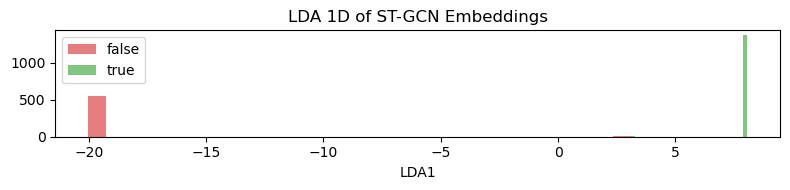

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# ───────────── 설정 ─────────────
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "flatten"  # "mean", "max", "flatten" 중 선택

def reduce_stgcn(arr):
    if arr is None or len(arr) == 0:
        return np.empty((0, 0))
    if AGG_METHOD == "mean":    return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":     return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten": return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

# ───────────── ST-GCN 임베딩 및 라벨 npy 직접 불러오기 ─────────────
def load_npy(split):
    base = DATA_ROOT / "stgcnpp" / split
    emb_path = base / "embeddings.npy"
    lbl_path = base / "labels.npy"
    if not emb_path.exists() or not lbl_path.exists():
        print(f"⚠️ {split} 경로에 필요한 파일이 없습니다. 스킵합니다.")
        return None, None
    emb = np.load(emb_path)
    lbl = np.load(lbl_path).ravel()
    return emb, lbl

X_tr, y_tr = load_npy("train")
X_va, y_va = load_npy("valid")
X_te, y_te = load_npy("test")

X_tr = reduce_stgcn(X_tr)
X_va = reduce_stgcn(X_va)
X_te = reduce_stgcn(X_te)

X_all = np.vstack([X_tr, X_va, X_te])
y_all = np.concatenate([y_tr, y_va, y_te])

# ───────────── 정규화 ─────────────
scaler = StandardScaler().fit(np.vstack([X_tr, X_va]))
X_all_scaled = scaler.transform(X_all)

# ───────────── LDA 변환 ─────────────
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_all_scaled, y_all)

# ───────────── 시각화 ─────────────
plt.figure(figsize=(8,2))
for label, color, name in zip([0,1], ['tab:red','tab:green'], ['false','true']):
    idx = y_all == label
    plt.hist(X_lda[idx], bins=30, color=color, label=name, alpha=0.6)
plt.xlabel('LDA1')
plt.title('LDA 1D of ST-GCN Embeddings')
plt.legend(); plt.tight_layout()
plt.show()